In [1]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)

USE_COMPLEX = False  # <--- Set True ONLY if you need complex PETSc
USE_CLEAN = False    # <--- Set True to remove existing environment

opts_str = " ".join(
  [o for c, o in [(USE_COMPLEX, "--complex"), (USE_CLEAN, "--clean")] if c]
)

get_ipython().run_line_magic("run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts_str}")

🔧 FEniCSx Setup Configuration
PETSc type      : real
Clean install   : False

⚠️  Google Drive not mounted — using local cache (/content)

🔧 Installing FEniCSx environment...

🔍 Verifying PETSc type...
✅ Installed: Real PETSc (float64)

✨ Loading FEniCSx Jupyter magic... %%fenicsx registered

✅ FEniCSx setup complete!

Next steps:
  1. Run %%fenicsx --info to verify installation
  2. Use %%fenicsx in cells to run FEniCSx code
  3. Use -np N for parallel execution (e.g., %%fenicsx -np 4)

📌 Note: Real PETSc is installed
   - Recommended for most FEM problems
   - For complex problems, reinstall with --complex


---

In [2]:
%%fenicsx -np 1

from dolfinx.mesh import create_unit_interval
from dolfinx.fem import functionspace
from mpi4py import MPI

N = 8
mesh = create_unit_interval(MPI.COMM_WORLD, N)

for p in [2, 3]:
    V = functionspace(mesh, ("Lagrange", p))
    coords = V.tabulate_dof_coordinates()

    print(f"\nP{p} DOF coordinates:")
    for i in range(min(20, len(coords))):
        print(f"  DOF {i:2d}: x = {coords[i, 0]:.6f}")


P2 DOF coordinates:
  DOF  0: x = 0.000000
  DOF  1: x = 0.125000
  DOF  2: x = 0.062500
  DOF  3: x = 0.250000
  DOF  4: x = 0.187500
  DOF  5: x = 0.375000
  DOF  6: x = 0.312500
  DOF  7: x = 0.500000
  DOF  8: x = 0.437500
  DOF  9: x = 0.625000
  DOF 10: x = 0.562500
  DOF 11: x = 0.750000
  DOF 12: x = 0.687500
  DOF 13: x = 0.875000
  DOF 14: x = 0.812500
  DOF 15: x = 1.000000
  DOF 16: x = 0.937500

P3 DOF coordinates:
  DOF  0: x = 0.000000
  DOF  1: x = 0.125000
  DOF  2: x = 0.034549
  DOF  3: x = 0.090451
  DOF  4: x = 0.250000
  DOF  5: x = 0.159549
  DOF  6: x = 0.215451
  DOF  7: x = 0.375000
  DOF  8: x = 0.284549
  DOF  9: x = 0.340451
  DOF 10: x = 0.500000
  DOF 11: x = 0.409549
  DOF 12: x = 0.465451
  DOF 13: x = 0.625000
  DOF 14: x = 0.534549
  DOF 15: x = 0.590451
  DOF 16: x = 0.750000
  DOF 17: x = 0.659549
  DOF 18: x = 0.715451
  DOF 19: x = 0.875000


In [3]:
%%fenicsx

import numpy as np
import matplotlib.pyplot as plt
import basix
from basix import ElementFamily, CellType, LagrangeVariant
from dolfinx.mesh import create_unit_interval
from dolfinx.fem import functionspace
from mpi4py import MPI

# ==========================
# Parameters
# ==========================
N = 8
p_list = [1, 2, 3]
n_plot = 200

x_nodes = np.linspace(0.0, 1.0, N + 1)

fig, axes = plt.subplots(len(p_list), 1, figsize=(10, 8), sharex=True)

# Get actual DOF coordinates from FEniCSx mesh
mesh_fem = create_unit_interval(MPI.COMM_WORLD, N)

for ax, p in zip(axes, p_list):

    # Use same variant as FEniCSx
    # P1, P2: equispaced, P3+: gll (Gauss-Lobatto-Legendre)
    if p <= 2:
        variant = LagrangeVariant.equispaced
    else:
        variant = LagrangeVariant.gll_warped  # FEniCSx default for P3+

    element = basix.create_element(
        ElementFamily.P,
        CellType.interval,
        p,
        variant
    )

    # Get actual DOF coordinates
    V = functionspace(mesh_fem, ("Lagrange", p))
    dof_coords = V.tabulate_dof_coordinates()[:, 0]
    total_dofs = len(dof_coords)

    ndofs = element.dim  # p + 1

    x_global = np.zeros(N * n_plot)
    phi_global = np.zeros((total_dofs, N * n_plot))

    # Reference points
    xi = np.linspace(0.0, 1.0, n_plot)
    X_ref = xi[:, None]

    # Tabulate basis functions on reference element
    tab = element.tabulate(0, X_ref)[0, :, :, 0]

    for cell in range(N):
        x0 = x_nodes[cell]
        x1 = x_nodes[cell + 1]
        h = x1 - x0

        idx = slice(cell * n_plot, (cell + 1) * n_plot)
        x_global[idx] = x0 + h * xi

        # Global DOF mapping (matches FEniCSx order)
        if p == 1:
            cell_dofs = [cell, cell + 1]
        elif p == 2:
            if cell == 0:
                cell_dofs = [0, 1, 2]
            else:
                cell_dofs = [2*cell - 1, 2*cell + 1, 2*cell]
        elif p == 3:
            if cell == 0:
                cell_dofs = [0, 1, 2, 3]
            else:
                cell_dofs = [3*cell - 2, 3*cell + 1, 3*cell - 1, 3*cell]

        for ldof, gdof in enumerate(cell_dofs):
            phi_global[gdof, idx] += tab[:, ldof]

    # Plot basis functions
    for i in range(total_dofs):
        for cell in range(N):
            idx = slice(cell * n_plot, (cell + 1) * n_plot)

            vals = phi_global[i, idx]
            # Skip cells where basis has no support
            if np.allclose(vals, 0.0, atol=1e-12):
                continue

            ax.plot(x_global[idx], vals, lw=1.5)

    # DOF markers at nodal positions
    ax.plot(dof_coords, np.ones_like(dof_coords), "ko", ms=4, zorder=5)

    # Cell boundaries
    for x in x_nodes:
        ax.axvline(x, color="k", ls=":", lw=0.8, alpha=0.6)

    ax.set_ylim(-0.4, 1.2)
    ax.set_ylabel("basis value")
    ax.set_title(
        f"Lagrange P{p} basis functions (N={N}, {total_dofs} basis functions)",
        fontsize=12, fontweight='bold'
    )
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("lagrange_basis_comparison_cellwise.png", dpi=200, bbox_inches="tight")
plt.close()
print("✓ Generated: lagrange_basis_comparison_cellwise.png")

✓ Generated: lagrange_basis_comparison_cellwise.png


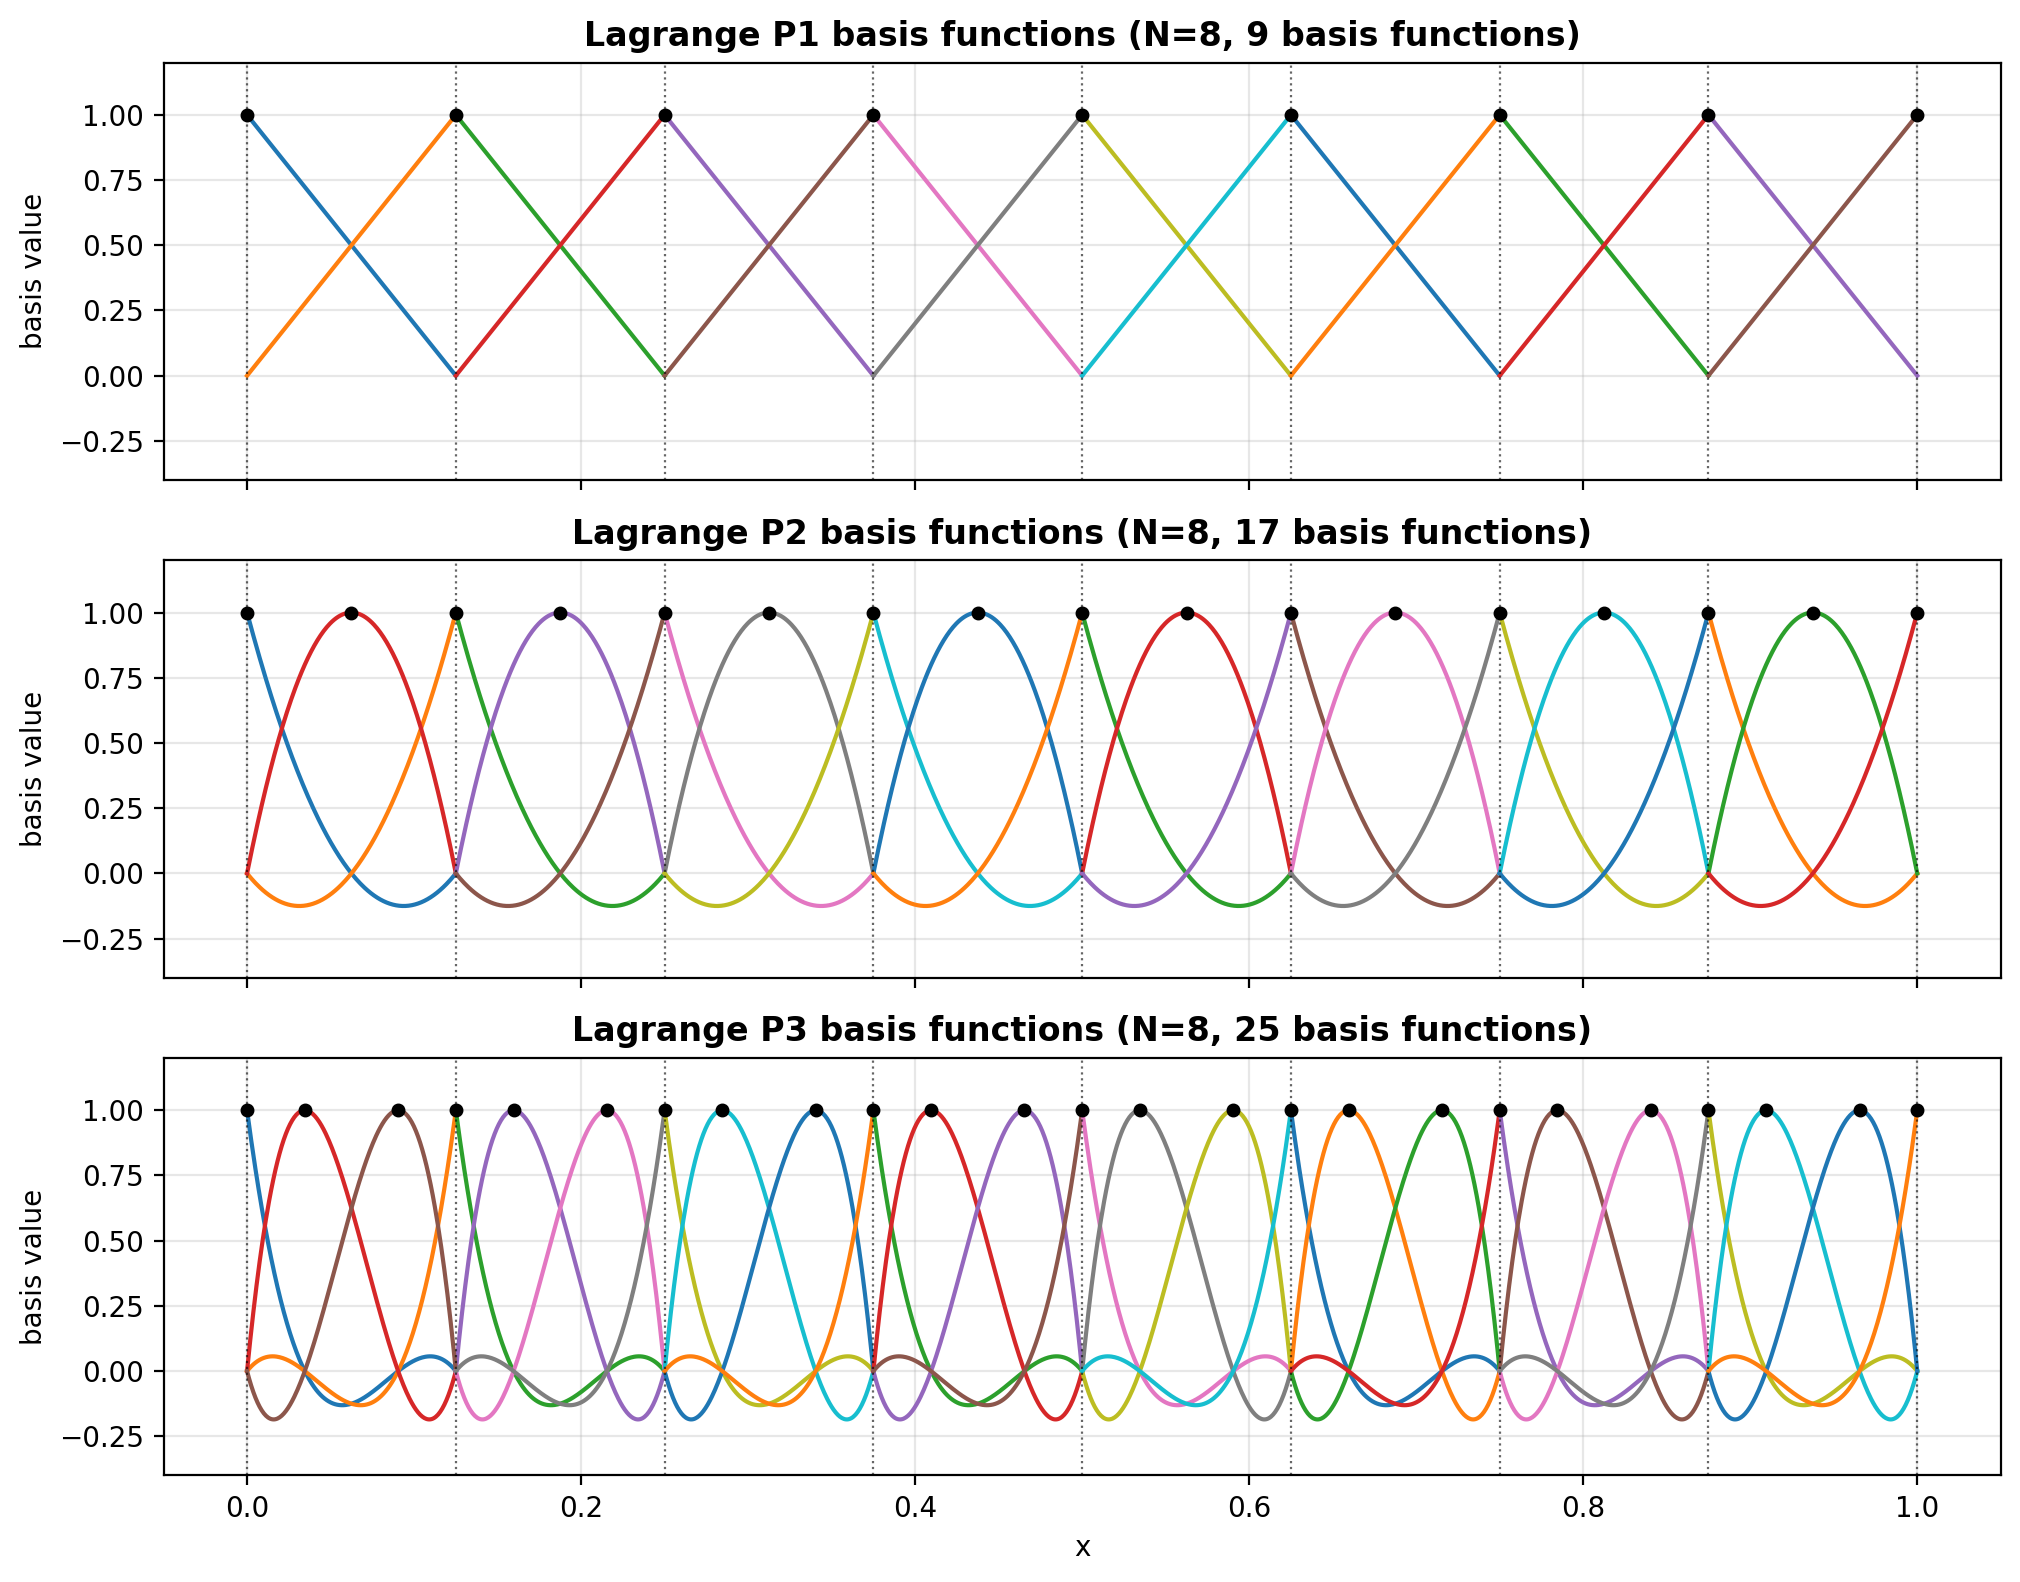

In [4]:
from IPython.display import Image, display

display(Image("lagrange_basis_comparison_cellwise.png"))

---

In [5]:
%%fenicsx -np 4

import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
import dolfinx
import ufl
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells

# =============================================================================
# PROBLEM SETUP
# =============================================================================

def g_numpy(x):
    """Exact solution (NumPy)"""
    return x + np.sin(np.pi * x) * np.cos(3 * np.pi * x)

def g_ufl(x):
    """Exact solution (UFL)"""
    return x[0] + ufl.sin(ufl.pi * x[0]) * ufl.cos(3 * ufl.pi * x[0])

# =============================================================================
# CONVERGENCE STUDY
# =============================================================================

def compute_errors(N, degree):
    """Compute L2 and H1 errors for given mesh size and polynomial degree"""
    mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, N)
    V = dolfinx.fem.functionspace(mesh, ("Lagrange", degree))

    u = dolfinx.fem.Function(V)
    u.interpolate(lambda x: g_numpy(x[0]))

    x = ufl.SpatialCoordinate(mesh)
    u_exact = g_ufl(x)

    # Compute errors
    L2_err = dolfinx.fem.assemble_scalar(dolfinx.fem.form((u - u_exact)**2 * ufl.dx))
    H1_err = dolfinx.fem.assemble_scalar(dolfinx.fem.form(
        ufl.inner(ufl.grad(u - u_exact), ufl.grad(u - u_exact)) * ufl.dx
    ))

    L2_err = np.sqrt(mesh.comm.allreduce(L2_err, op=MPI.SUM))
    H1_err = np.sqrt(mesh.comm.allreduce(H1_err, op=MPI.SUM))

    return 1.0 / N, L2_err, H1_err

def convergence_study(degree, Ns=[10, 20, 40, 80]):
    """Run convergence study and print table"""
    results = [compute_errors(N, degree) for N in Ns]

    if MPI.COMM_WORLD.rank != 0:
        return None

    print(f"\n=== P{degree} FEM Convergence ===")
    print(" h        L2 error     rate      H1 error     rate")
    print("-" * 52)

    for i, (h, L2, H1) in enumerate(results):
        if i == 0:
            print(f"{h:6.4f}  {L2:10.3e}    ---   {H1:10.3e}    ---")
        else:
            h0, L20, H10 = results[i-1]
            rate_L2 = np.log(L20 / L2) / np.log(h0 / h)
            rate_H1 = np.log(H10 / H1) / np.log(h0 / h)
            print(f"{h:6.4f}  {L2:10.3e}  {rate_L2:6.2f}  {H1:10.3e}  {rate_H1:6.2f}")

    return np.array(results).T  # (h, L2, H1)

# =============================================================================
# VISUALIZATION
# =============================================================================

def eval_fem_on_grid(u, mesh, x_grid):
    """Evaluate FEM function on a dense grid (MPI-safe)"""
    tree = bb_tree(mesh, mesh.topology.dim)
    values = np.zeros_like(x_grid)

    for i, x in enumerate(x_grid):
        point = np.array([[x, 0.0, 0.0]], dtype=mesh.geometry.x.dtype)
        cells = compute_colliding_cells(mesh, compute_collisions_points(tree, point), point)

        if cells.num_nodes > 0 and len(cells.links(0)) > 0:
            values[i] = u.eval(point, [cells.links(0)[0]])[0]

    return values

def compute_visualization_data(N, degree):
    """Compute FEM solution and error for visualization"""
    if MPI.COMM_WORLD.rank != 0:
        return None

    # Serial computation for visualization
    mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_SELF, N)
    V = dolfinx.fem.functionspace(mesh, ("Lagrange", degree))
    u = dolfinx.fem.Function(V)
    u.interpolate(lambda x: g_numpy(x[0]))

    # Get nodes
    V_lin = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
    u_lin = dolfinx.fem.Function(V_lin)
    u_lin.interpolate(lambda x: g_numpy(x[0]))
    x_nodes = V_lin.tabulate_dof_coordinates()[:, 0]
    u_nodes = u_lin.x.array

    # Evaluate on dense grid
    x_ref = np.linspace(0.0, 1.0, 2000)
    g_ref = g_numpy(x_ref)
    u_fem = eval_fem_on_grid(u, mesh, x_ref)

    return {
        'x_ref': x_ref,
        'g_ref': g_ref,
        'u_fem': u_fem,
        'error': g_ref - u_fem,
        'x_nodes': x_nodes,
        'u_nodes': u_nodes,
        'degree': degree
    }

# =============================================================================
# PLOTTING
# =============================================================================

def plot_convergence(conv_results):
    """Plot convergence rates"""
    if MPI.COMM_WORLD.rank != 0:
        return

    fig, ax = plt.subplots(figsize=(8, 6))

    colors = {'L2': ['red', 'blue', 'green'], 'H1': ['orange', 'cyan', 'lime']}
    markers = ['o', 's', '^']

    for p, marker in zip([1, 2, 3], markers):
        h, L2, H1 = conv_results[p]

        ax.loglog(h, L2, f"{marker}-", color=colors['L2'][p-1],
                  linewidth=2, markersize=6, label=f"P{p} L2")
        ax.loglog(h, H1, f"{marker}--", color=colors['H1'][p-1],
                  linewidth=2, markersize=6, label=f"P{p} H1")

        # Reference slopes
        ax.loglog(h, L2[0]*(h/h[0])**(p+1), "k:", alpha=0.3, linewidth=1)
        ax.loglog(h, H1[0]*(h/h[0])**p, "k:", alpha=0.3, linewidth=1)

    ax.invert_xaxis()
    ax.set_xlabel("Mesh size h", fontsize=12)
    ax.set_ylabel("Error", fontsize=12)
    ax.set_title("FEM Convergence (L2 and H1 errors)", fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, ncol=2)
    ax.grid(True, which="both", ls=":", alpha=0.5)

    plt.tight_layout()
    plt.savefig("convergence.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Generated: convergence.png")

def plot_solutions(vis_data, N):
    """Plot FEM solutions comparison"""
    if MPI.COMM_WORLD.rank != 0:
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['blue', 'green', 'purple']

    for ax, data, color in zip(axes, vis_data, colors):
        ax.plot(data['x_ref'], data['g_ref'], 'k-', linewidth=2.5, label='Exact')
        ax.plot(data['x_ref'], data['u_fem'], color=color, linewidth=1.5,
                linestyle='--', label=f"FEM P{data['degree']}")
        ax.plot(data['x_nodes'], data['u_nodes'], 'o', color=color, markersize=6,
                markerfacecolor=color, markeredgecolor='white', markeredgewidth=1)

        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('u', fontsize=11)
        ax.set_title(f"P{data['degree']} (N={N})", fontsize=13, fontweight='bold')
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])

    plt.tight_layout()
    plt.savefig("solutions_combined.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Generated: solutions_combined.png")

def plot_errors(vis_data, N):
    """Plot pointwise errors"""
    if MPI.COMM_WORLD.rank != 0:
        return

    fig, ax = plt.subplots(figsize=(12, 5))
    colors = ['red', 'orange', 'brown']

    print("\nPointwise Error Statistics:")
    for data, color in zip(vis_data, colors):
        err = data['error']
        max_err = np.max(np.abs(err))
        ax.plot(data['x_ref'], err, color=color, linewidth=2.5,
                label=f"P{data['degree']} (max|e|={max_err:.4f})")
        print(f"  P{data['degree']}: max|error| = {max_err:.6f}, "
              f"L2-norm ≈ {np.sqrt(np.mean(err**2)):.6f}")

    ax.axhline(y=0, color='lightgray', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('Error (Exact − FEM)', fontsize=12)
    ax.set_title(f'Pointwise Error Comparison (N={N})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])

    plt.tight_layout()
    plt.savefig("errors_combined.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Generated: errors_combined.png")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if MPI.COMM_WORLD.rank == 0:
    print("=" * 60)
    print("CONVERGENCE STUDY")
    print("=" * 60)

# Run convergence studies
conv_results = {}
for degree in [1, 2, 3]:
    result = convergence_study(degree)
    if result is not None:
        conv_results[degree] = result

# Plot convergence
plot_convergence(conv_results)

if MPI.COMM_WORLD.rank == 0:
    print("\n" + "=" * 60)
    print("VISUALIZATION")
    print("=" * 60 + "\n")

# Compute visualization data
N_vis = 8
vis_data = [compute_visualization_data(N_vis, deg) for deg in [1, 2, 3]]
vis_data = [d for d in vis_data if d is not None]

# Plot solutions and errors
plot_solutions(vis_data, N_vis)
plot_errors(vis_data, N_vis)

if MPI.COMM_WORLD.rank == 0:
    print("\n" + "=" * 60)
    print("ALL DONE - Generated 3 figures:")
    print("  1. convergence.png")
    print("  2. solutions_combined.png")
    print("  3. errors_combined.png")
    print("=" * 60)

CONVERGENCE STUDY

=== P1 FEM Convergence ===
 h        L2 error     rate      H1 error     rate
----------------------------------------------------
0.1000   5.083e-02    ---    1.620e+00    ---
0.0500   1.303e-02    1.96   8.254e-01    0.97
0.0250   3.277e-03    1.99   4.147e-01    0.99
0.0125   8.204e-04    2.00   2.076e-01    1.00

=== P2 FEM Convergence ===
 h        L2 error     rate      H1 error     rate
----------------------------------------------------
0.1000   3.978e-03    ---    2.579e-01    ---
0.0500   5.055e-04    2.98   6.552e-02    1.98
0.0250   6.344e-05    2.99   1.645e-02    1.99
0.0125   7.939e-06    3.00   4.116e-03    2.00

=== P3 FEM Convergence ===
 h        L2 error     rate      H1 error     rate
----------------------------------------------------
0.1000   2.883e-04    ---    2.733e-02    ---
0.0500   1.825e-05    3.98   3.462e-03    2.98
0.0250   1.144e-06    4.00   4.343e-04    3.00
0.0125   7.158e-08    4.00   5.433e-05    3.00
✓ Generated: convergence.


Solutions comparison:



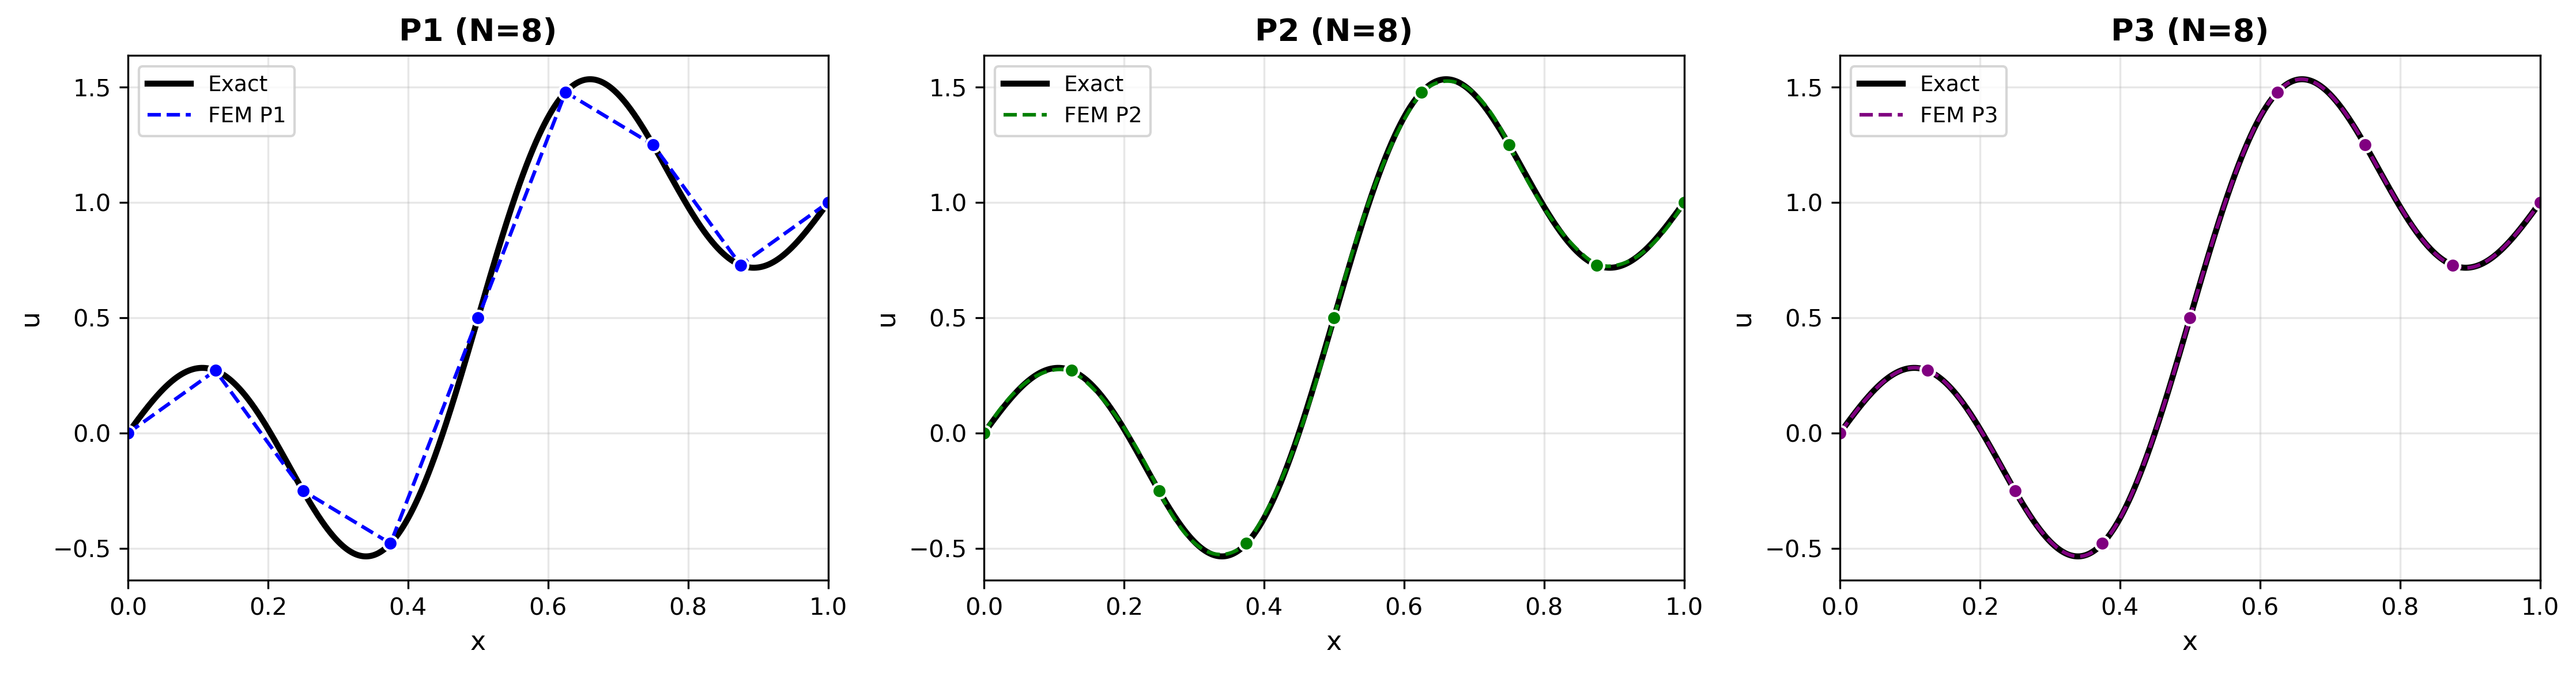


Errors comparison:



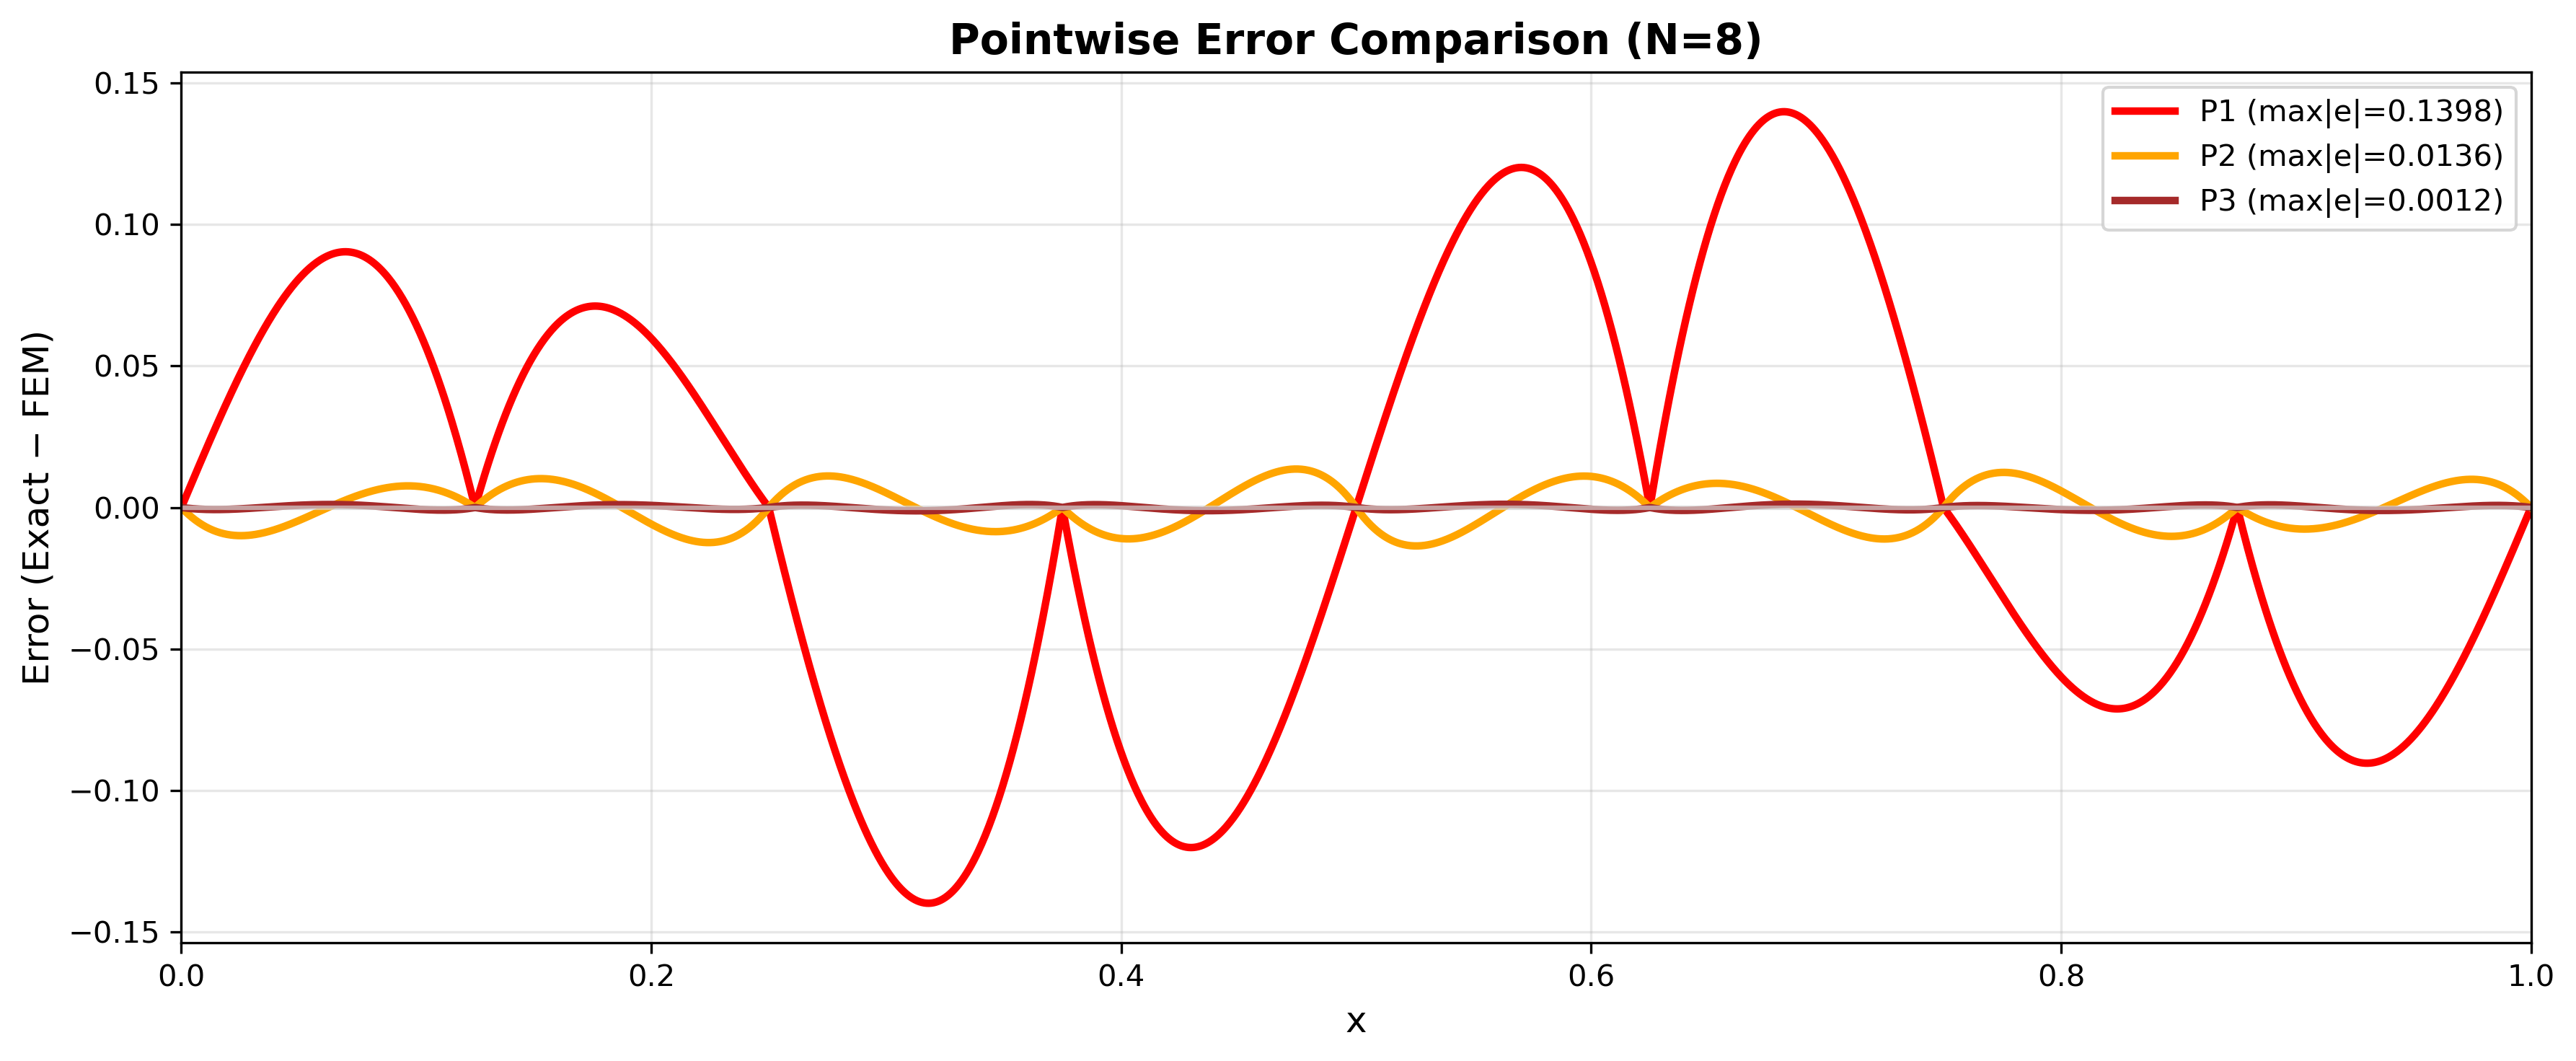

Convergence comparion:



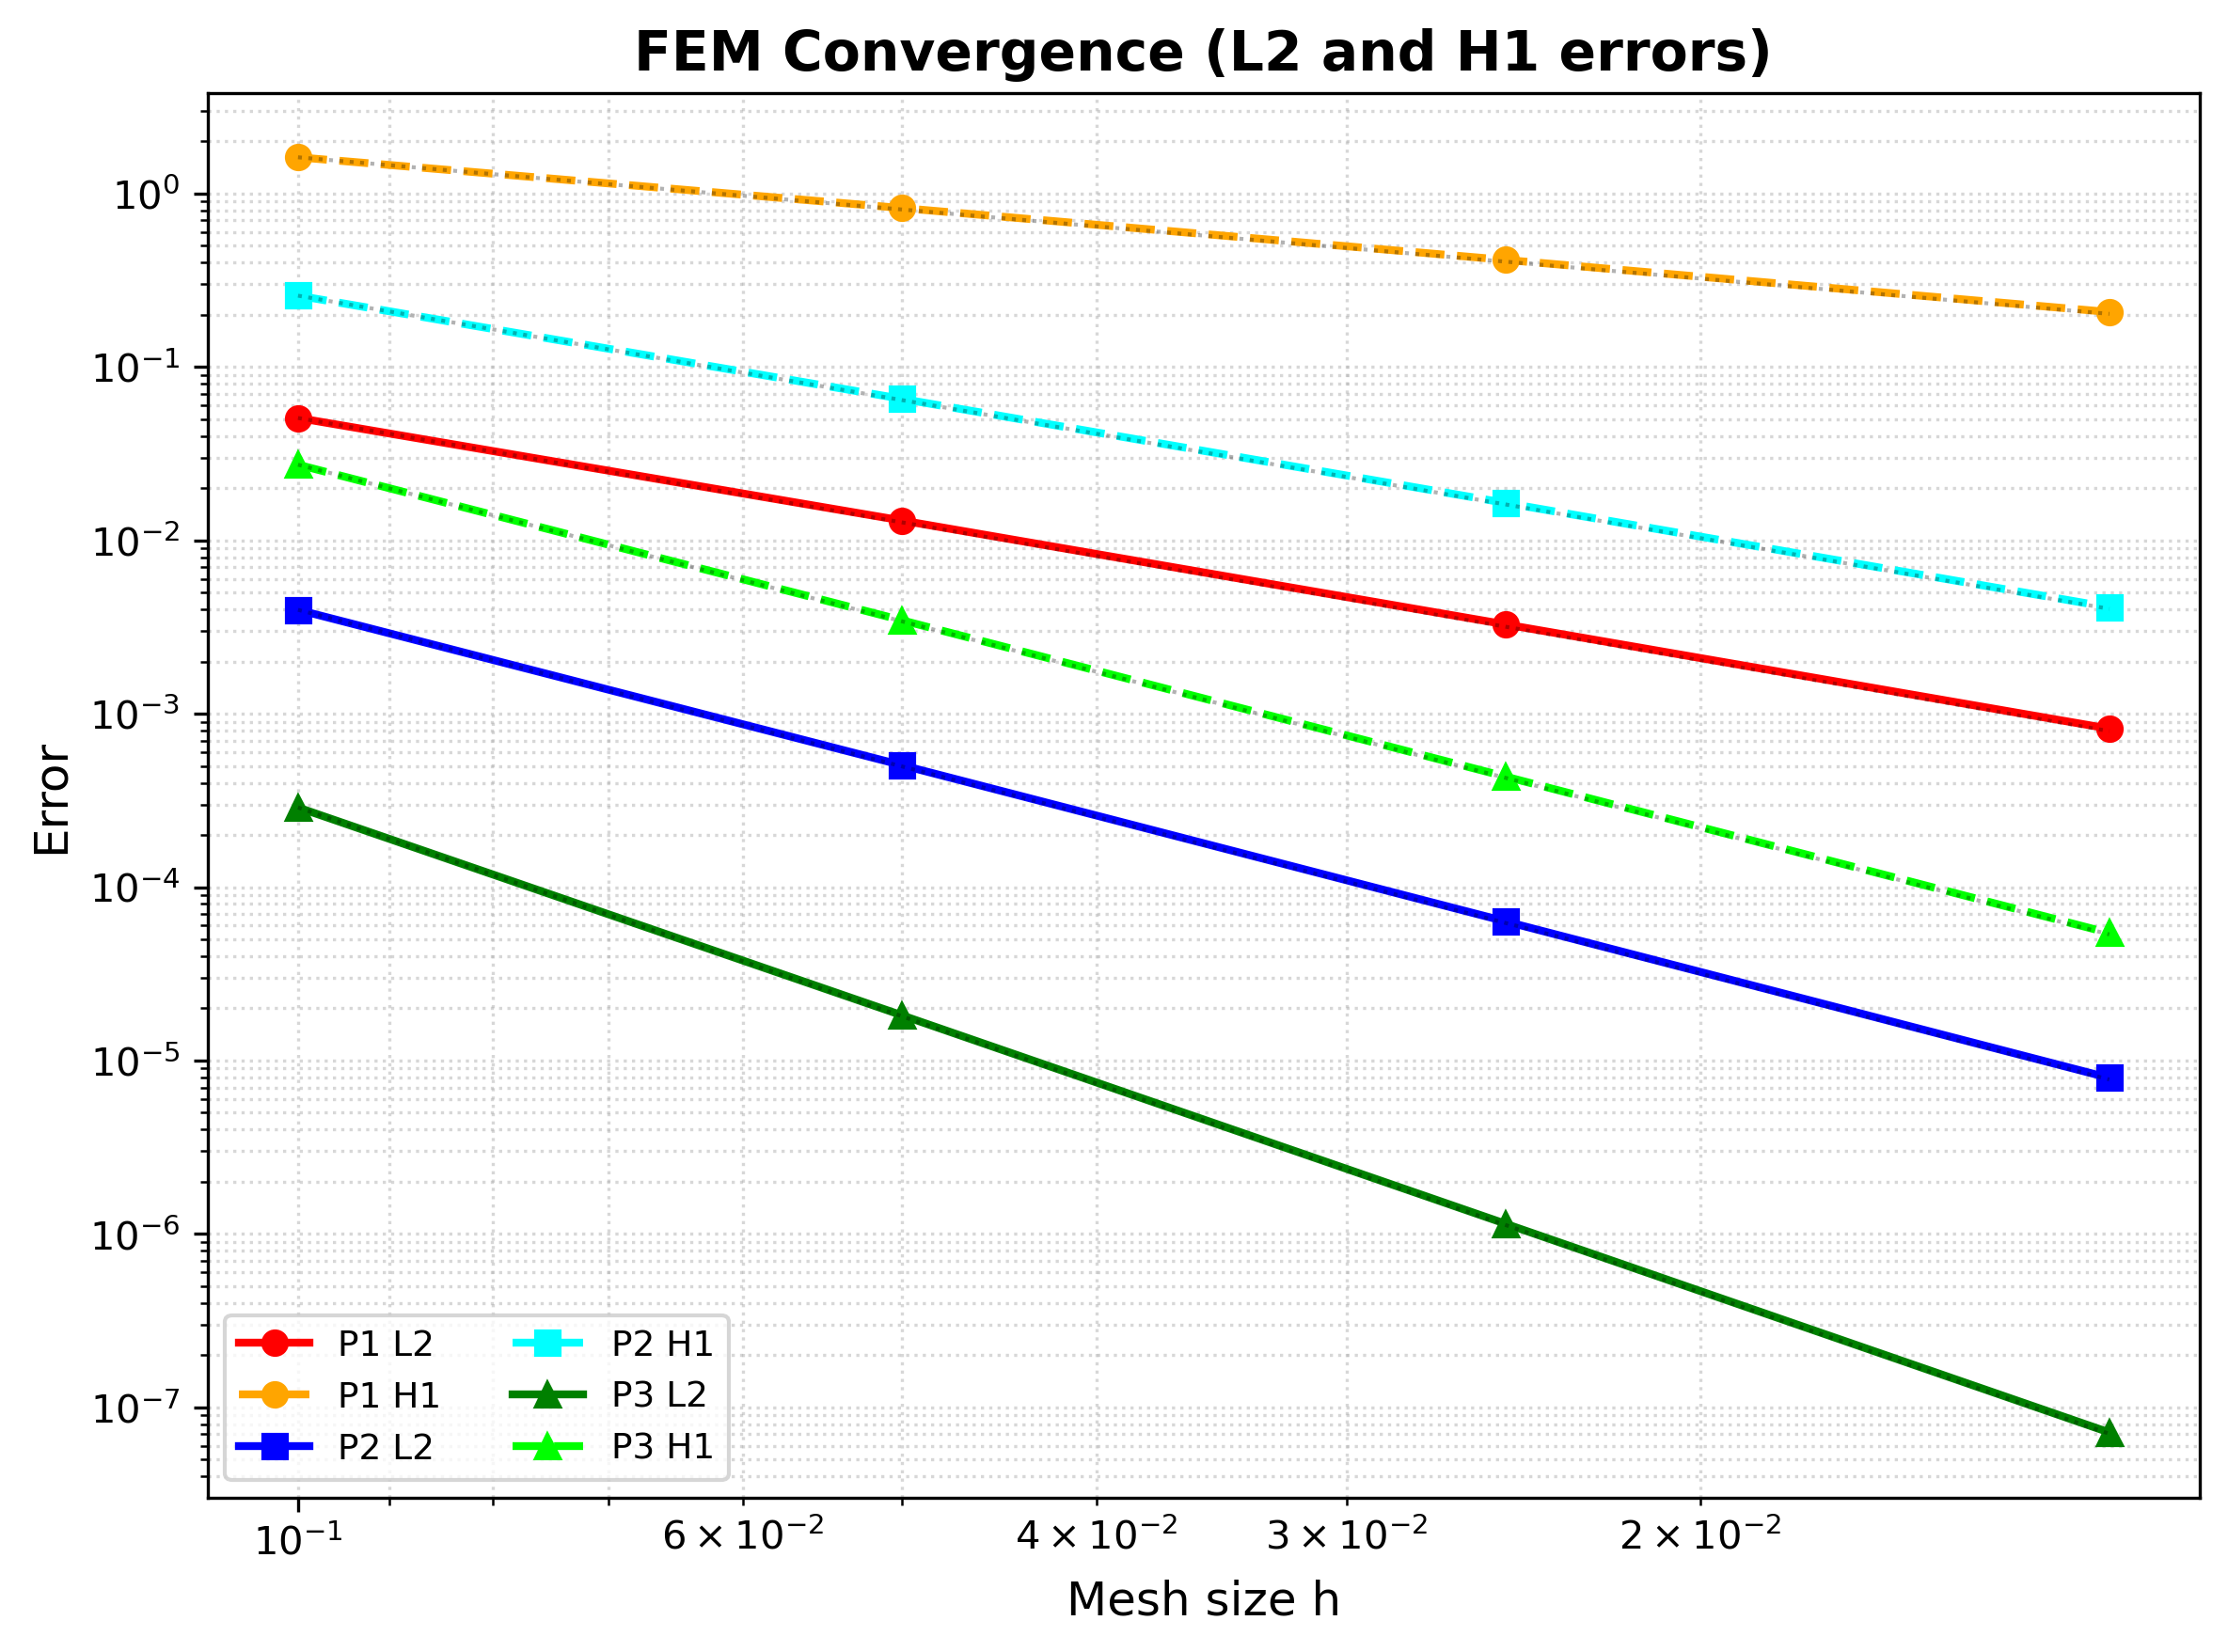

In [6]:
print("\nSolutions comparison:\n")
display(Image("solutions_combined.png"))

print("\nErrors comparison:\n")
display(Image("errors_combined.png"))

print("Convergence comparion:\n")
display(Image("convergence.png"))